In [1]:
import pickle

# Third-party
import astropy.coordinates as coord
from astropy.io import fits
from astropy.table import Table
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from scipy.stats import multivariate_normal
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.special import logsumexp
from scipy.ndimage import gaussian_filter
import pystan

import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.mpl_style import hesperia
from gala.units import galactic
from pyia import GaiaData

from coordinates import pal5_lead_frame, pal5_trail_frame, pal5_c

In [2]:
sm = pystan.StanModel('../stan/binned_model_stream_only.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1a979dfe246e700401dd7cdb7eec2520 NOW.


In [3]:
mask_zlim = 23.7
mask_pts = np.load('../data/concave_hull_z{:.1f}.npz'.format(mask_zlim))['pts']
path_concavehull = mpl.path.Path(mask_pts)

In [5]:
phi1_lim = (mask_pts[:, 0].min(), mask_pts[:, 0].max())
phi2_lim = (mask_pts[:, 1].min(), mask_pts[:, 1].max())

TODO: 
- load simulation data
- convert to phi1/phi2 coordinates, use .transform_to(gc.Pal5)
- filter out star particles in foreground/background
- Produce variables `phi1`, `phi2` with the sim particle coordinates

In [ ]:
# stuff

In [6]:
ridge = Table.read('../data/pal5_ridgeline.csv')
ridge_c = coord.SkyCoord(ridge['ra'], ridge['dec'], unit=u.deg).transform_to(gc.Pal5)
ridge_phi1 = ridge_c.phi1.degree
ridge_phi2 = ridge_c.phi2.degree

# HACK:
ridge_phi1 = np.concatenate((ridge_phi1[16:], [-18, -0.23, 10, 0.23, 0.01, -0.01]))
ridge_phi2 = np.concatenate((ridge_phi2[16:], [1.8, -0.23, 3.5, 0.23, 0.22, -0.22]))

NameError: name 'phi1' is not defined

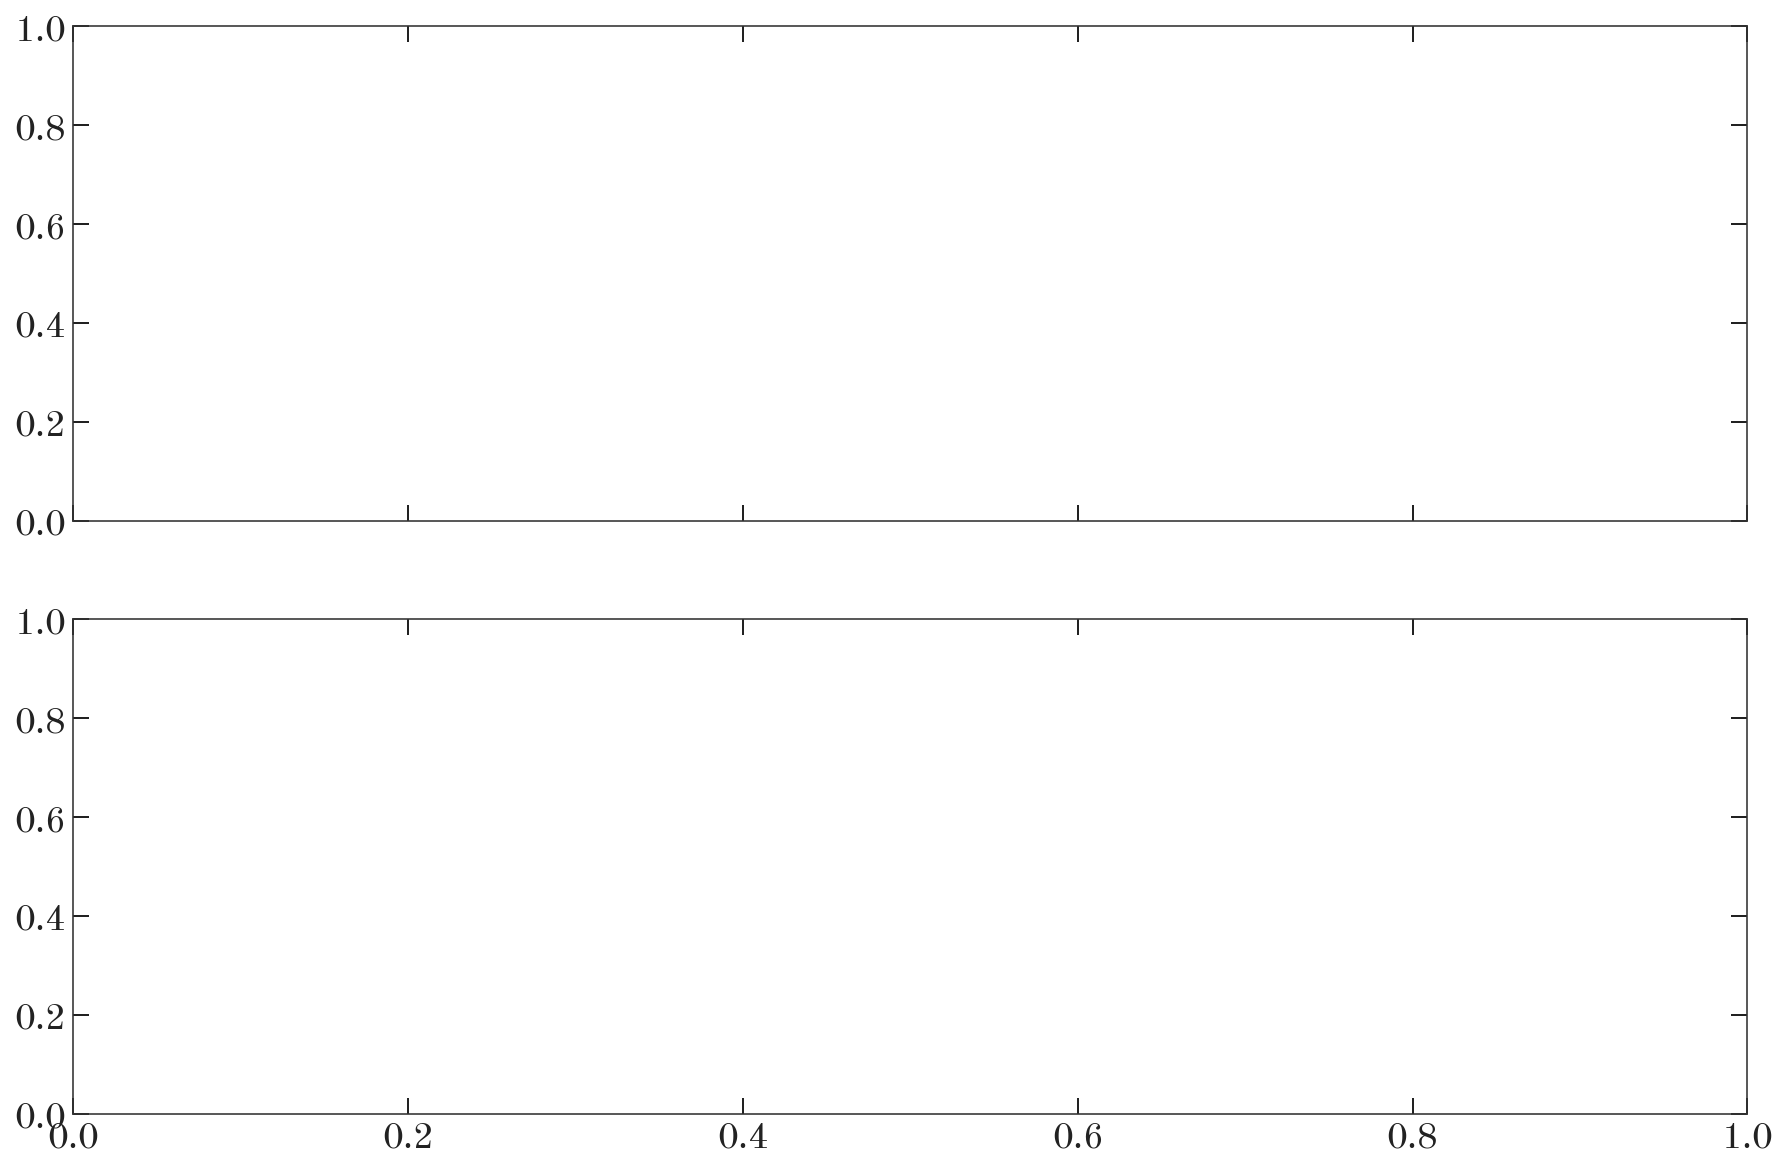

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True, sharey=True)

for ax in axes:
    ax.plot(phi1, phi2, marker='o', ms=1., ls='none', color='k', alpha=1)
    ax.set_aspect('equal')
    ax.set_xlim(-20, 15)
    ax.set_ylim(-4, 6)

ax.scatter(ridge_phi1, ridge_phi2, zorder=100, color='tab:orange')

# ---

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

for ax in axes:
    ax.plot(phi1, phi2, marker='o', ms=1., ls='none', color='k', alpha=1)
    ax.set_aspect('equal')
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)

ax.scatter(ridge_phi1, ridge_phi2, zorder=100, color='tab:orange')

In [9]:
xx = ridge_phi1[ridge_phi1 > 0]
yy = ridge_phi2[ridge_phi1 > 0]
l_poly = InterpolatedUnivariateSpline(xx[xx.argsort()], yy[xx.argsort()], k=1)

xx = ridge_phi1[ridge_phi1 < 0]
yy = ridge_phi2[ridge_phi1 < 0]
t_poly = InterpolatedUnivariateSpline(xx[xx.argsort()], yy[xx.argsort()], k=1)

dpix = 0.1
# dpix = 0.05
xbins = np.arange(phi1_lim[0], phi1_lim[1]+1e-3, dpix)
ybins = np.arange(phi2_lim[0], phi2_lim[1]+1e-3, dpix)

h_phi1 = 1
# h_phi1 = 0.5
l_nodes = np.concatenate(([0.01], np.arange(0.2, 9+1e-3, h_phi1)))
t_nodes = np.concatenate((np.arange(-17, 0.2+1e-3, h_phi1), [-0.01]))

nodes = np.concatenate((t_nodes, l_nodes))
phi2_nodes = np.concatenate((t_poly(t_nodes), l_poly(l_nodes)))

(-4, 6)

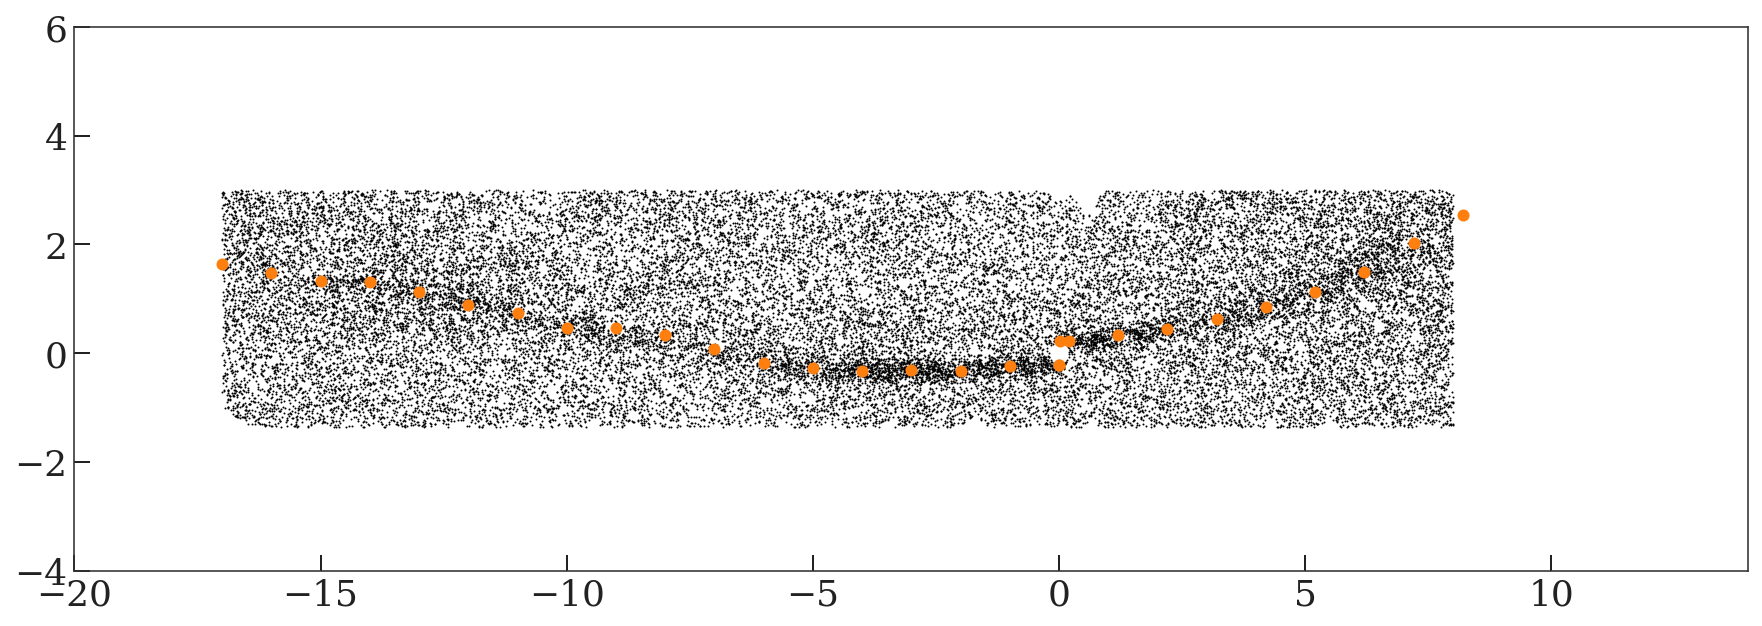

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

ax.plot(phi1, phi2, marker='o', ms=1, ls='none', color='k', alpha=1)
ax.scatter(nodes, phi2_nodes, zorder=100, color='tab:orange')
ax.set_xlim(-20, 14)
ax.set_ylim(-4, 6)

In [11]:
def make_data(H, log_S, xbins, ybins, phi1_nodes, phi2_nodes):
    xe_c = 0.5 * (xbins[:-1] + xbins[1:])
    ye_c = 0.5 * (ybins[:-1] + ybins[1:])
    xx, yy = np.stack(list(map(np.ravel, np.meshgrid(xe_c, ye_c))))
    
    data = {}
    data['n_pix'] = H.size
    data['hh'] = H.T.ravel().astype(np.int32)
    data['log_S'] = log_S.T.ravel()
    data['x'] = xx
    data['y'] = yy

    data['n_nodes'] = len(phi1_nodes)
    data['phi1_nodes'] = phi1_nodes
    data['phi2_nodes_init'] = phi2_nodes
    data['h_nodes'] = np.full_like(phi1_nodes, 1. * h_phi1)

    data['bg_nodes'] = np.arange(xbins.min()-5, xbins.max()+5+1e-3, 5)
    data['n_bg_nodes'] = len(data['bg_nodes'])
    
    return data, xbins, ybins

In [12]:
cl_mask = gc.Pal5(phi1=phi1*u.deg, phi2=phi2*u.deg).separation(pal5_c) < 0.25*u.deg
_phi1 = phi1.copy()
_phi1[cl_mask] = np.nan
H, xbins, ybins = np.histogram2d(_phi1, phi2, 
                                 bins=(xbins, ybins))
shape = H.T.shape

In [13]:
xcen = 0.5*(xbins[1:] + xbins[:-1])
ycen = 0.5*(ybins[1:] + ybins[:-1])
xx, yy = np.meshgrid(xcen, ycen)
grid_points = np.array([xx.ravel(), yy.ravel()]).T

In [18]:
xlim = (data['x'].min(), data['x'].max())
ylim = (data['y'].min(), data['y'].max())

2

In [20]:
nchains = 1
init_dict = {}
init_dict['d_phi2_nodes'] = np.zeros(data['n_nodes'])
init_dict['log_w_nodes'] = np.full(data['n_nodes'], np.log(0.3))
init_dict['log_a_nodes'] = np.full(data['n_nodes'], np.log(20))

inits = [init_dict]

niter = 2048

In [ ]:
fit = sm.optimizing(data=data, init=inits[0], iter=niter,
                    verbose=True)

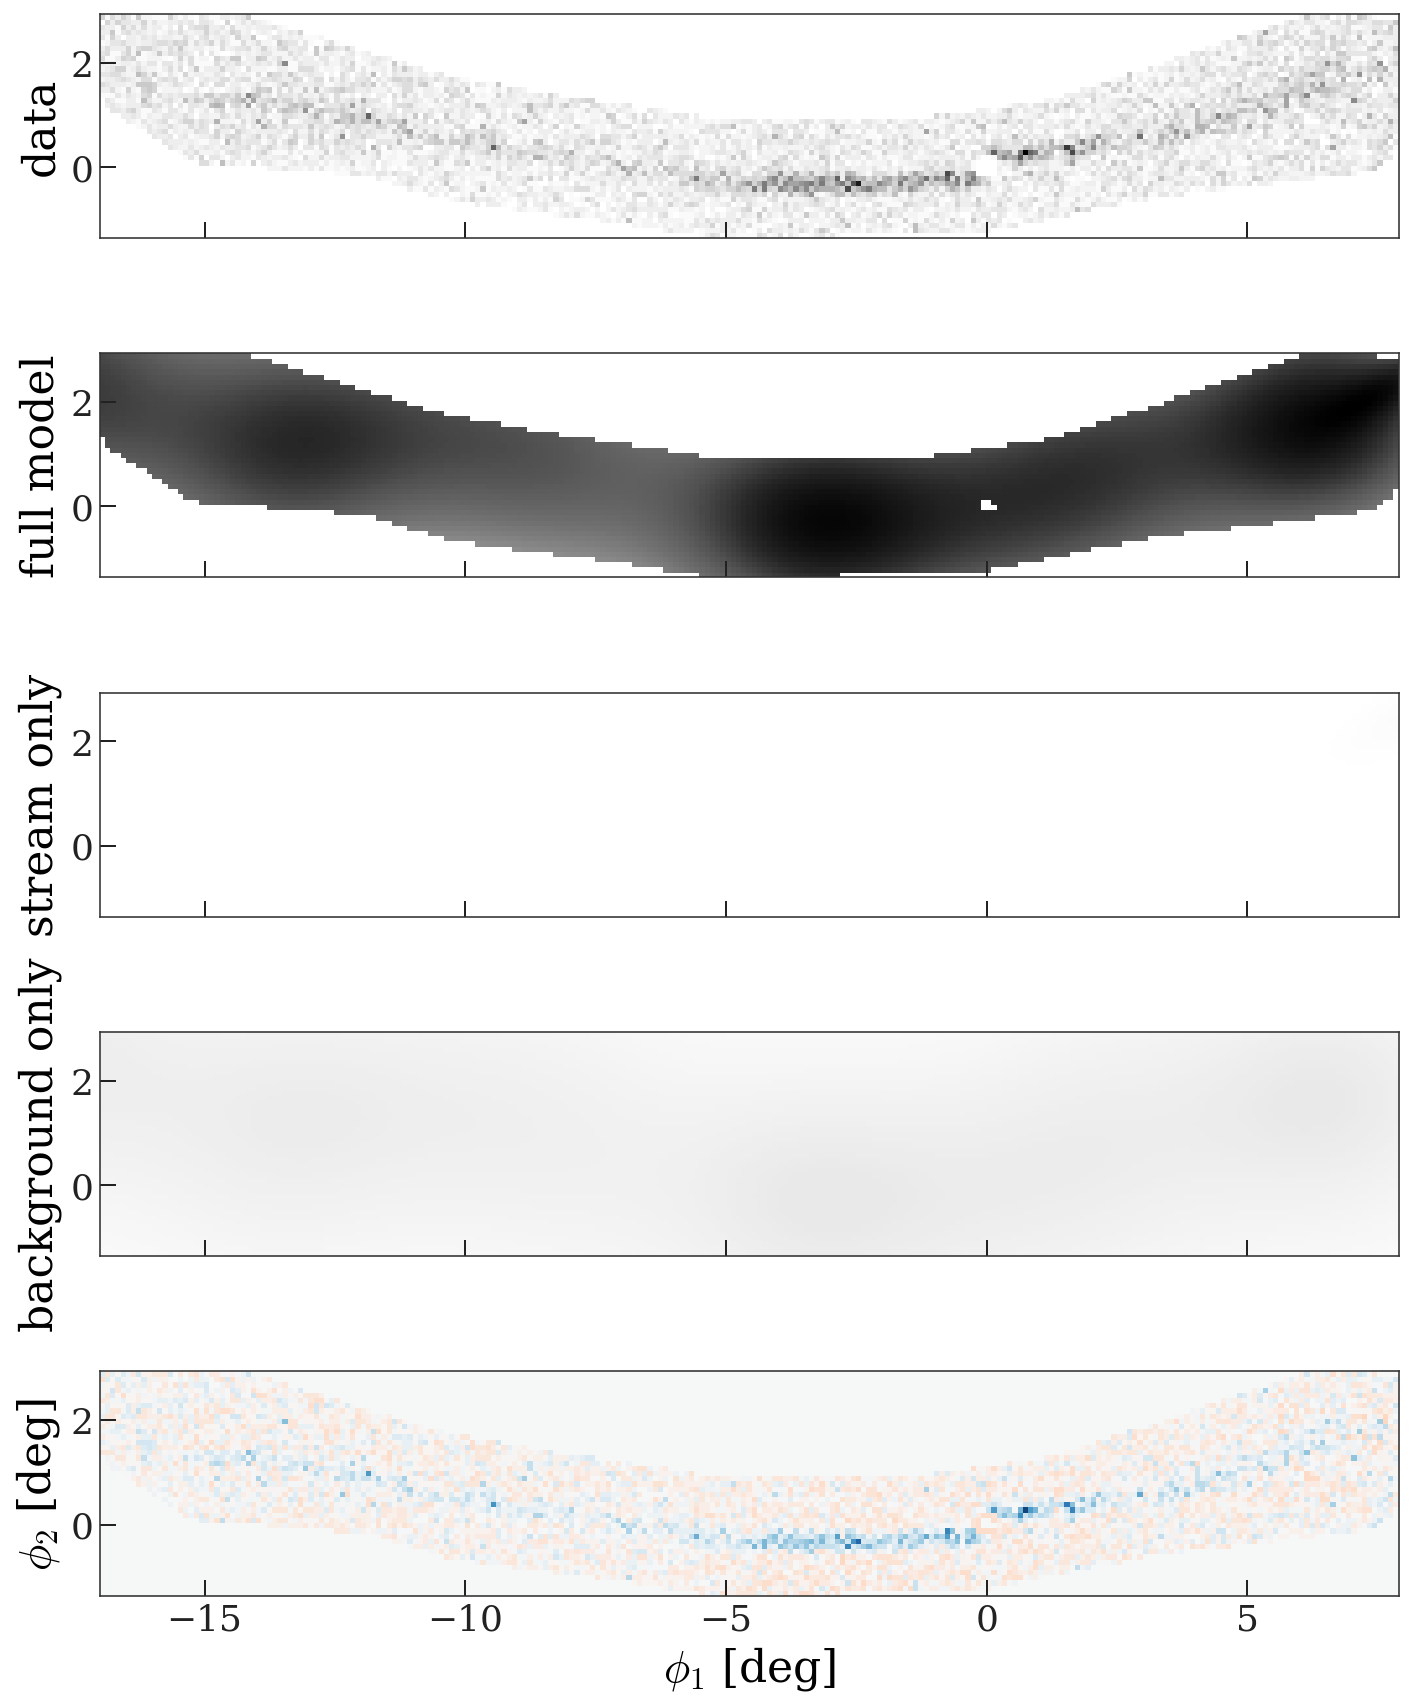

In [22]:
fig, axes = plt.subplots(4, 1, figsize=(12, 12), 
                         sharex=True, sharey=True)

ax = axes[0]
ax.pcolormesh(xbins, ybins, data['hh'].reshape(shape),
              cmap='Greys')
ax.set_ylabel('data')

ax = axes[1]
ax.pcolormesh(xbins, ybins, np.exp(fit['xmod'].reshape(shape)),
              cmap='Greys')#, vmin=1e-4, vmax=3)
ax.set_ylabel('full model')

ax = axes[2]
ax.pcolormesh(xbins, ybins, np.exp(fit['log_gd1_int'].reshape(shape)),
              cmap='Greys', vmin=1e-4, vmax=25)
ax.set_ylabel('stream only')

ax = axes[3]
model = np.exp(fit['xmod'].reshape(shape))
resid = data['hh'].reshape(shape) - model
im = ax.pcolormesh(xbins, ybins, resid,
                   cmap='RdBu', vmin=-20, vmax=20)
# fig.colorbar(im)
ax.set_ylabel('residuals')

ax.set_xlabel(r'$\phi_1$ [deg]')
ax.set_ylabel(r'$\phi_2$ [deg]')

for ax in axes:
    ax.set_aspect('equal')
    
fig.tight_layout()
# fig.savefig('../plots/{}-2d-fit.png'.format(name), dpi=250)

# Implement the density model in Python

In [24]:
def ln_normal_2d(x, mu, cov):
    x = np.array(x)
    mu = np.array(mu)    
    _, logdet = np.linalg.slogdet(cov)
    Cinv = np.linalg.inv(cov)
    quad_form = (x - mu).T.dot(Cinv).dot(x - mu)
    return -0.5 * (logdet + quad_form + 2 * np.log(2*np.pi))

In [25]:
def evaluate_stream_model(fit, data, x, y):
    phi1 = data['phi1_nodes']
    phi2 = fit['phi2_nodes']
    log_amp = fit['log_a_nodes']
    w = np.exp(fit['log_w_nodes'])
    h = data['h_nodes']
    R = fit['R']
    C = fit['C']
    
    x = np.atleast_1d(x)
    y = np.atleast_1d(y)
    
    ln_val = np.zeros((data['n_nodes'], len(x)))
    for i in range(data['n_nodes']):
        ln_val[i] = [log_amp[i] + ln_normal_2d([x[n], y[n]], 
                                                mu=[phi1[i], phi2[i]], cov=C[i])
                     for n in range(len(x))]
    
    return logsumexp(ln_val, axis=0)

In [26]:
dense_xbins = np.arange(xbins.min(), xbins.max(), 0.05)
dense_ybins = np.arange(ybins.min(), ybins.max(), 0.05)

dense_xc = 0.5 * (dense_xbins[:-1] + dense_xbins[1:])
dense_yc = 0.5 * (dense_ybins[:-1] + dense_ybins[1:])
dense_x, dense_y = map(np.ravel, np.meshgrid(dense_xc, dense_yc))
dense_shape = (dense_ybins.size-1, dense_xbins.size-1)

In [27]:
py_hh = evaluate_stream_model(fit, data, dense_x, dense_y)
py_hh = np.exp(py_hh.reshape(dense_shape))

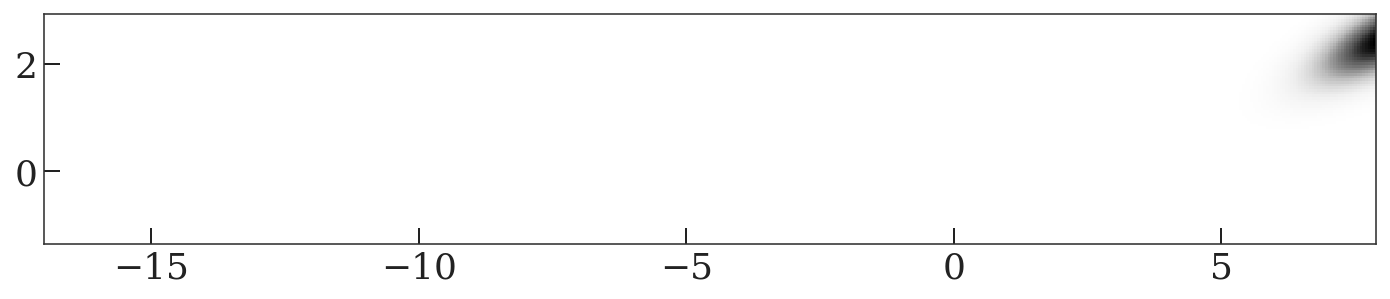

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4), 
                         sharex=True, sharey=True)

ax.pcolormesh(dense_xbins, dense_ybins, py_hh, #np.arcsinh(py_hh / 5),
              cmap='Greys')

ax.set_aspect('equal')
    
fig.tight_layout()

In [29]:
phi1_bins = np.arange(xbins.min(), xbins.max()+1e-3, 0.5)
phi2_bins = dense_yc
phi1_bins_c = 0.5 * (phi1_bins[:-1] + phi1_bins[1:])

widths = []
for p1, p2 in zip(phi1_bins[:-1], phi1_bins[1:]):
    phi1_mask = (dense_xc > p1) & (dense_xc <= p2)
    phi2_vals = py_hh[:, phi1_mask].sum(axis=1) / phi1_mask.sum()
    widths.append(1 / (np.sqrt(2*np.pi) * phi2_vals.max()))

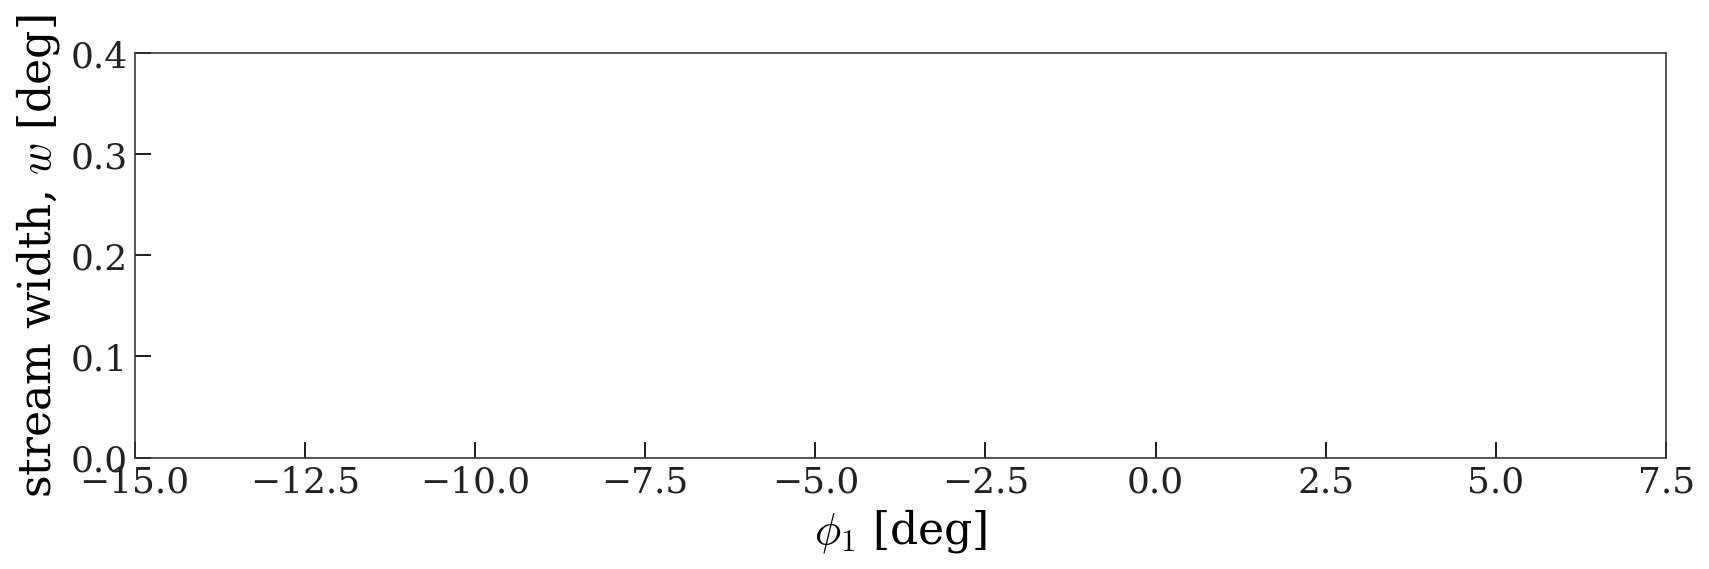

In [30]:
fig = plt.figure(figsize=(12, 4))
plt.plot(phi1_bins_c, widths)
plt.xlim(-15, 7.5)
plt.ylim(0., 0.4)
plt.xlabel(r'$\phi_1$ [deg]')
plt.ylabel('stream width, $w$ [deg]')
fig.set_facecolor('w')
fig.tight_layout()
fig.savefig('../plots/{}-stream-width.png'.format(name), dpi=250)